In [2]:
import pandas as pd
import tensorflow as tf
import seaborn as sns

In [3]:
df = pd.read_csv('BTC_USD_2014-11-03_2022-02-04-CoinDesk.csv')

In [4]:
df.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2014-11-03,324.467934,323.826186,333.539527,323.106623
1,BTC,2014-11-04,328.644408,324.424164,330.671610,320.902900
2,BTC,2014-11-05,337.921358,328.653046,342.384170,328.597125
3,BTC,2014-11-06,348.992860,337.921358,352.585895,336.236830
4,BTC,2014-11-07,341.459753,348.992860,351.651854,340.196145


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2651 non-null   object 
 1   Date                 2651 non-null   object 
 2   Closing Price (USD)  2651 non-null   float64
 3   24h Open (USD)       2651 non-null   float64
 4   24h High (USD)       2651 non-null   float64
 5   24h Low (USD)        2651 non-null   float64
dtypes: float64(4), object(2)
memory usage: 124.4+ KB


Text(0.5, 1.0, 'Closing Price of Bitcoin from 2013 to 2022')

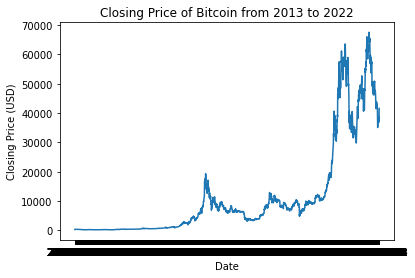

In [6]:
sns.lineplot(data=df, x='Date', y='Closing Price (USD)').set_title('Closing Price of Bitcoin from 2013 to 2022')

In [7]:
import csv
from datetime import datetime

In [8]:
timesteps = []
btc_price = []
with open('BTC_USD_2014-11-03_2022-02-04-CoinDesk.csv') as f:
    csv_reader = csv.reader(f, delimiter= ',')
    next(csv_reader)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
        btc_price.append(float(line[2])) # Closing price


In [9]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 0, 'Date')

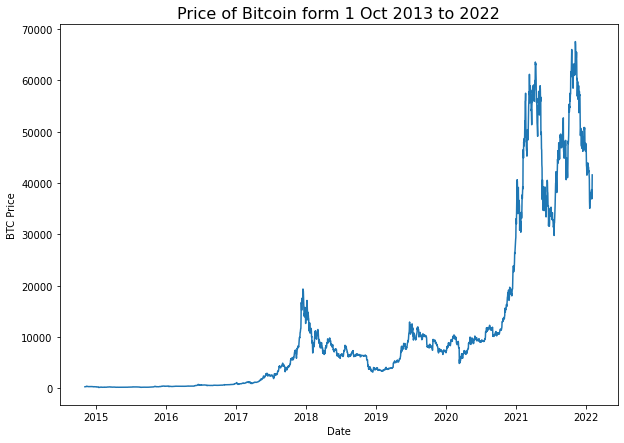

In [10]:
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin form 1 Oct 2013 to 2022", fontsize=16)
plt.xlabel("Date")

In [11]:
## Create train and test sets of our time series data
from sklearn.model_selection import train_test_split

## Don't do naive train_test split!!! Temporal coherence will be affected.
split_size = int(0.8 * len(df))

In [12]:
X_train, y_train = timesteps[:split_size], btc_price[:split_size]
X_test, y_test = timesteps[split_size:], btc_price[split_size:]

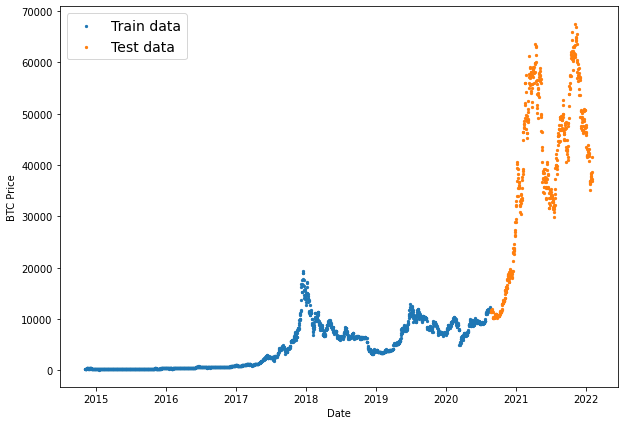

In [13]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label = "Train data")
plt.scatter(X_test, y_test, s =5, label = "Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

In [14]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

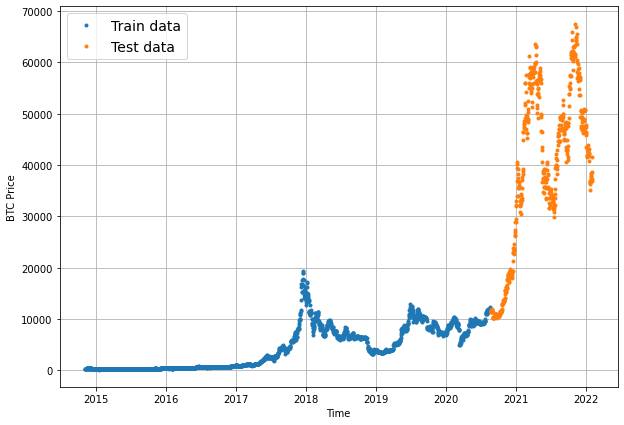

In [15]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

In [16]:
naive_forecast = np.array(y_test[:-1])

In [17]:
def MASE(y_true, y_pred):
    '''
    Mean Absolute Scaled Error implementation for use in tensorflow.

    Assumes no seasonality.
    '''

    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # mae naive forecase no seasonality
    mae_naive_ns = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

    return mae / mae_naive_ns


In [18]:
MASE(y_true=np.array(y_test[1:]), y_pred=naive_forecast).numpy()

0.998293997073448

In [19]:
def evaluate_preds(y_true, y_pred) -> dict:
    '''


    @warning Converts all datatypes to float32 when evaluating

    '''
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = MASE(y_true, y_pred)

    return {
        "MAE" : mae.numpy(),
        "MSE" : mse.numpy(),
        "RSME" : rmse.numpy(),
        "MAPE" : mape.numpy(),
        "MASE" : mase.numpy(),
    }

In [20]:
evaluate_preds(y_true=y_test[1:], y_pred = naive_forecast)

{'MAE': 1136.5298,
 'MSE': 2740204.0,
 'RSME': 1655.3562,
 'MAPE': 2.8412292,
 'MASE': 0.998294}

### Windowing our datasets - turning ts data into supervised learning

In [21]:
HORIZON = 1
WINDOW_SIZE = 7

In [22]:
def get_labelled_window(x, horizon = HORIZON):
    '''
    Creates labels for windowed dataset

    Input : [0,1,2,3,4,5,6,7]
    '''
    return x[:, :-horizon], x[:, -horizon:]

In [23]:
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8) + 1, axis = 0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]])>)

In [24]:
def make_windows(x, window_size = WINDOW_SIZE, horizon = HORIZON):
    '''
    Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
    '''
    # Create a nested window
    window_step = np.expand_dims(np.arange(window_size+ horizon), axis= 0)

    window_index = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T

    # Index on the target array
    windowed_array = x[window_index]

    # windows with labels
    windows, labels = get_labelled_window(windowed_array, horizon=horizon)
    return windows, labels


In [25]:
np.expand_dims(np.arange(8), axis = 0)

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [51]:
windows, labels = make_windows(np.array(btc_price))
windows.shape, labels.shape

((2644, 7), (2644, 1))

In [27]:
btc_price[0]

324.467934

In [28]:
windows[0]

array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
       344.745289, 357.239982])

In [29]:
for i in range(3):
    print(f"Window : {windows[i]} -> Label : {labels[i]}")

Window : [324.467934 328.644408 337.921358 348.99286  341.459753 344.745289
 357.239982] -> Label : [371.116917]
Window : [328.644408 337.921358 348.99286  341.459753 344.745289 357.239982
 371.116917] -> Label : [366.664633]
Window : [337.921358 348.99286  341.459753 344.745289 357.239982 371.116917
 366.664633] -> Label : [428.882925]


In [52]:
def train_test_split_windows(windows, labels, test_split= 0.2):
    '''
    Splits matching pairs of windows and labels into train and test splits
    '''

    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, train_labels, test_windows, test_labels

In [53]:
train_windows, train_labels, test_windows, test_labels = train_test_split_windows(windows, labels)

### Make a modelling checkpoint

In [54]:
import os

# Model checkpoint callback with a specific filename

def checkpoint_cb( model_name, save_path = 'models'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), verbose=0, save_best_only=True)


In [55]:
### Basic Linear Regression model
from tensorflow.keras import layers
tf.random.set_seed(42)

model1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear') # no activatoin
], name = 'Basic_Regression')

model1.compile(loss = "mae", optimizer = tf.keras.optimizers.Adam(), metrics=["mae", "mse"])

model1.fit(
    x = train_windows, 
    y = train_labels, 
    epochs=100, 
    verbose = 1,
    batch_size=128, 
    validation_data = (test_windows, test_labels), 
    callbacks=  [checkpoint_cb(model_name=model1.name)])

Epoch 1/100
17/17 [==============================] - 1s 23ms/step - loss: 1100.0088 - mae: 1100.0088 - mse: 3562633.0000 - val_loss: 4832.4214 - val_mae: 4832.4214 - val_mse: 35321380.0000
Epoch 2/100
17/17 [==============================] - 0s 21ms/step - loss: 326.0253 - mae: 326.0253 - mse: 339046.6562 - val_loss: 1938.8119 - val_mae: 1938.8119 - val_mse: 7271532.5000
Epoch 3/100
17/17 [==============================] - 0s 19ms/step - loss: 238.5033 - mae: 238.5033 - mse: 216512.0469 - val_loss: 1862.6833 - val_mae: 1862.6833 - val_mse: 6723281.0000
Epoch 4/100
17/17 [==============================] - 0s 19ms/step - loss: 217.9016 - mae: 217.9016 - mse: 189999.0000 - val_loss: 1797.5853 - val_mae: 1797.5853 - val_mse: 6169264.5000
Epoch 5/100
17/17 [==============================] - 0s 19ms/step - loss: 209.6864 - mae: 209.6864 - mse: 181247.8594 - val_loss: 1759.8129 - val_mae: 1759.8129 - val_mse: 5802266.0000
Epoch 6/100
17/17 [==============================] - 1s 36ms/step - los

In [56]:
model1.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 625us/step - loss: 1272.8014 - mae: 1272.8014 - mse: 3129840.5000


[1272.8013916015625, 1272.8013916015625, 3129840.5]

In [57]:
model1 = tf.keras.models.load_model('models/Basic_Regression')

In [58]:
model1.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 625us/step - loss: 1146.1456 - mae: 1146.1456 - mse: 2788494.7500


[1146.1456298828125, 1146.1456298828125, 2788494.75]

In [59]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [60]:
model_preds = make_preds(model1, test_windows)

In [61]:
model_res = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred = model_preds)

In [64]:
model_res

{'MAE': 1146.1455,
 'MSE': 2788495.0,
 'RSME': 1669.8788,
 'MAPE': 2.8602996,
 'MASE': 1.0055571}